In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Make charts look nice for the thesis
sns.set_style("whitegrid")

In [84]:
# Load only the first sheet (main)

#df = pd.read_excel('UK2025Risk.J.xlsx')
#df = pd.read_excel('UK2024.J.xlsx')
#df = pd.read_excel('UK2023Risk.J.xlsx')
#df = pd.read_excel('UK2022Risk.J.xlsx')
df = pd.read_excel('UK2021Risk.J.xlsx')


# Check if you have all the statuses you need (active, cancelled, complete, etc.)
print("Statuses found in data:")
print(df['tender_status'].value_counts())

Statuses found in data:
tender_status
complete        13715
active           4023
planned          2215
cancelled         381
unsuccessful      107
Name: count, dtype: int64


In [85]:
# --- FORCE CLEANING FOR 2021 ---

# 1. Define the only statuses we want to keep
# We strictly remove 'active', 'planned', 'planning' to match the other years
final_statuses = ['complete', 'cancelled', 'unsuccessful', 'withdrawn']

# 2. Apply the filter and OVERWRITE the dataframe
print(f"Row count before filter: {len(df)}")
df = df[df['tender_status'].isin(final_statuses)].copy()
print(f"Row count after filter:  {len(df)}")

# 3. Verify it worked
print("\nremaining statuses (Should only be Complete/Cancelled/Unsuccessful):")
print(df['tender_status'].value_counts())

Row count before filter: 21625
Row count after filter:  14203

remaining statuses (Should only be Complete/Cancelled/Unsuccessful):
tender_status
complete        13715
cancelled         381
unsuccessful      107
Name: count, dtype: int64


In [86]:
# 1. Define Industry Sectors
sector_labels = {
    '45': 'Construction', '72': 'IT & Computer Services', 
    '79': 'Consulting & Business', '85': 'Health & Social Work', 
    '35': 'Security & Defense', '60': 'Transport'
}

df['sector_code'] = df['tender_classification_id'].astype(str).str[:2]
df['industry_label'] = df['sector_code'].map(sector_labels).fillna('Other')

# 2. Add Industry Dummies and Clean Duplicates
# This prevents the "duplicate labels" error if you run the cell twice
dummy_df = pd.get_dummies(df['industry_label'], prefix='is')
df = pd.concat([df.loc[:, ~df.columns.duplicated()], dummy_df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]

# 3. Add Flags and Lead Time (Neutral SME fix for 2021)
if 'tender_suitability_sme' in df.columns:
    df['sme_flag'] = df['tender_suitability_sme'].map({True: 1, False: 0}).fillna(0)
else:
    df['sme_flag'] = 0 # Padding for 2021

df['accelerated_flag'] = df['tender_procedure_isAccelerated'].map({True: 1, False: 0}).fillna(0)
df['lead_time_days'] = (pd.to_datetime(df['tender_contractPeriod_startDate'], utc=True) - 
                        pd.to_datetime(df['date'], utc=True)).dt.days.fillna(0)

# 4. THE SELECTOR: Force X to match 2023 exactly
pca_features = [
    'tender_value_amount', 'lead_time_days', 'sme_flag', 'accelerated_flag',
    'is_Construction', 'is_IT & Computer Services', 'is_Consulting & Business',
    'is_Health & Social Work', 'is_Security & Defense', 'is_Transport', 'is_Other'
]

# Extract and clean
X = df.reindex(columns=pca_features, fill_value=0)
X = X.dropna()

# 5. Standardize and Run
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(X)
pca = PCA()
pca_results = pca.fit_transform(X_Scaled)

print(f"2021 Run Complete: {X.shape[1]} features, {pca.n_components_} components.")

2021 Run Complete: 11 features, 11 components.


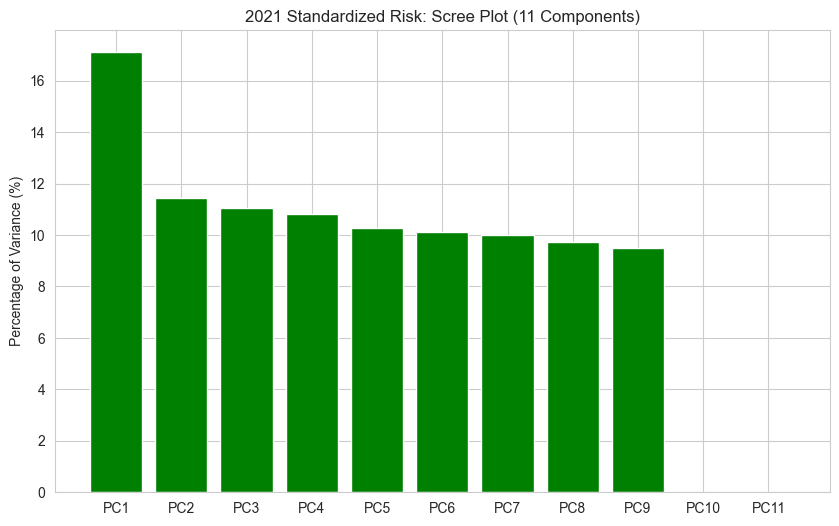

Verified: PCA is now running on 11 standardized features.


In [87]:
# 1. Define the 11 standard risk features (Must match 2023 exactly)
pca_features = [
    'tender_value_amount', 'lead_time_days', 'sme_flag', 'accelerated_flag',
    'is_Construction', 'is_IT & Computer Services', 'is_Consulting & Business',
    'is_Health & Social Work', 'is_Security & Defense', 'is_Transport', 'is_Other'
]

# 2. Extract ONLY these features (using reindex to handle any missing ones)
X = df.reindex(columns=pca_features, fill_value=0)

# 3. Clean and Scale
X = X.dropna()
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(X)

# 4. Run PCA
pca = PCA()
pca_results = pca.fit_transform(X_Scaled)

# 5. Updated Plotting Code (Forces the labels to match the 11 components)
pc_labels = [f'PC{i+1}' for i in range(pca.n_components_)]
variances = pca.explained_variance_ratio_ * 100

plt.figure(figsize=(10, 6))
plt.bar(pc_labels, variances, color='green')
plt.ylabel('Percentage of Variance (%)')
plt.title('2021 Standardized Risk: Scree Plot (11 Components)')
plt.show()

print(f"Verified: PCA is now running on {pca.n_components_} standardized features.")

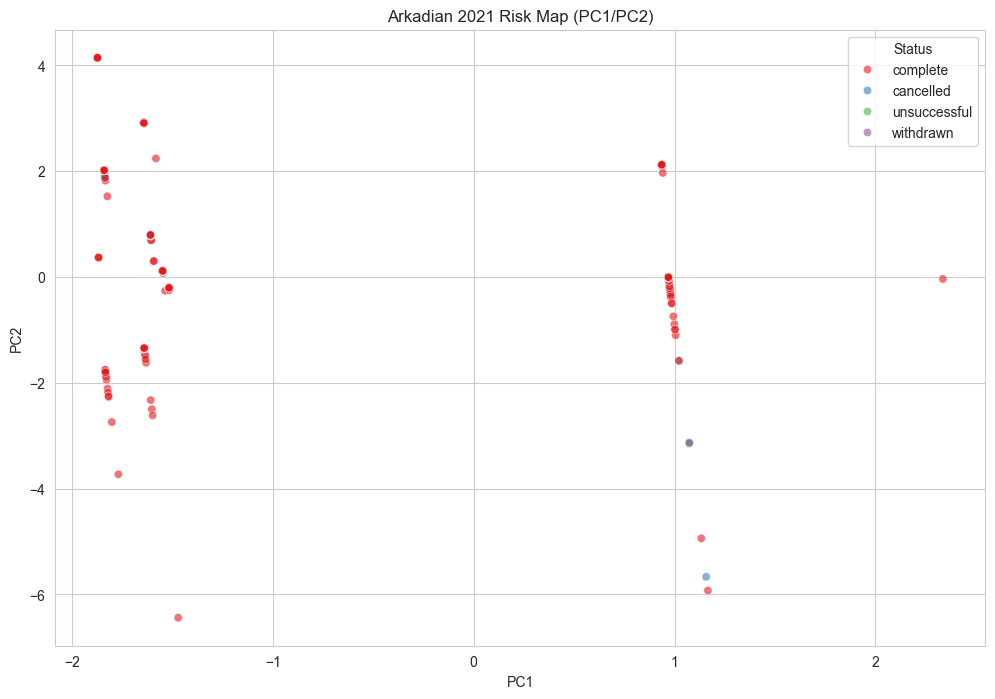

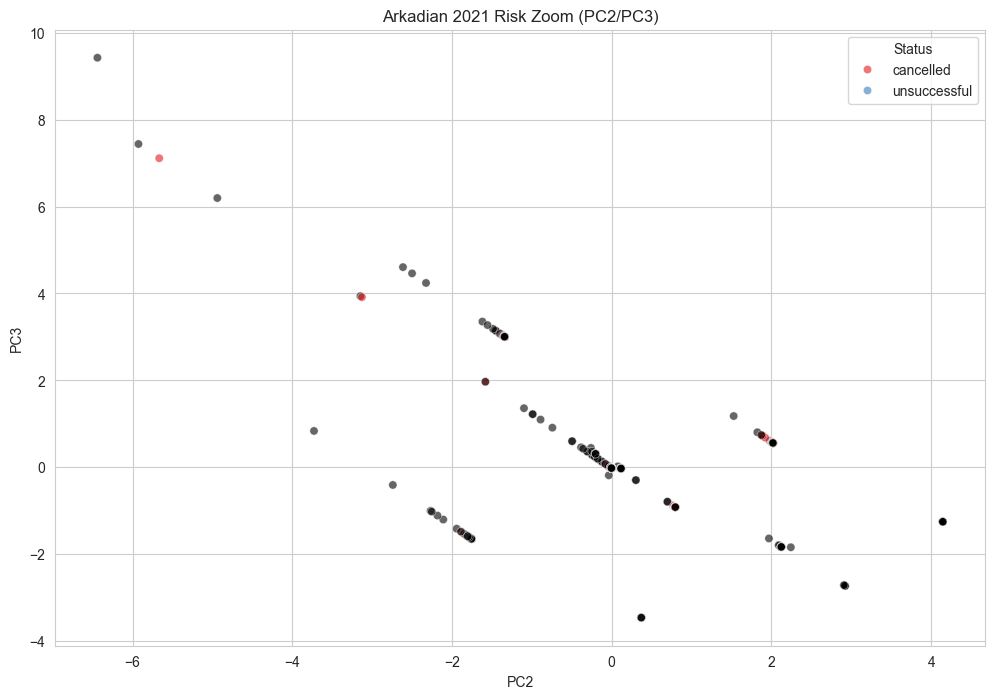

In [88]:
# --- PART A: Main Risk Map (PC1 vs PC2) ---
pc_map = pd.DataFrame(pca_results[:, :2], columns=['PC1', 'PC2'])

# FIX: Filter status to match only the 5,859 surviving rows
pc_map['Status'] = df.loc[X.index, 'tender_status'].values

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pc_map, x='PC1', y='PC2', hue='Status', 
    hue_order=['complete', 'cancelled', 'unsuccessful', 'withdrawn'],
    palette='Set1', alpha=0.6
)
plt.title('Arkadian 2021 Risk Map (PC1/PC2)')
plt.show()

# --- PART B: Risk Zoom (PC2 vs PC3) ---
pc_deep_map = pd.DataFrame(pca_results[:, 1:3], columns=['PC2', 'PC3'])

# FIX: Again, filter status to match the PCA index
pc_deep_map['Status'] = df.loc[X.index, 'tender_status'].values

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pc_deep_map, x='PC2', y='PC3', hue='Status', 
    hue_order=['cancelled', 'unsuccessful'],
    palette='Set1', alpha=0.6
)
plt.title('Arkadian 2021 Risk Zoom (PC2/PC3)')
plt.show()

In [89]:
# Create loadings table for all variables
# We use X.columns because that is the final table we sent to the PCA
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(pca.n_components_)], 
    index=X.columns
)

# Look at the recipe for PC2/3
print("-PC1 Drivers-")
print(loadings['PC1'].sort_values(ascending=False))


-PC1 Drivers-
is_Other                     7.634456e-01
tender_value_amount          8.809009e-03
sme_flag                     1.110223e-16
accelerated_flag            -4.444829e-03
lead_time_days              -2.886467e-02
is_Security & Defense       -7.033009e-02
is_Transport                -1.297020e-01
is_IT & Computer Services   -2.013995e-01
is_Construction             -2.367614e-01
is_Health & Social Work     -3.843463e-01
is_Consulting & Business    -3.874425e-01
Name: PC1, dtype: float64


In [90]:
print("-PC2 Drivers-")
print(loadings['PC2'].sort_values(ascending=False))

-PC2 Drivers-
is_Consulting & Business     6.498965e-01
accelerated_flag             2.849167e-01
is_IT & Computer Services    1.666480e-01
is_Transport                 1.905483e-02
is_Other                     7.866364e-03
lead_time_days               6.761928e-04
sme_flag                    -2.775558e-17
is_Security & Defense       -1.442534e-02
tender_value_amount         -2.651288e-01
is_Construction             -3.071985e-01
is_Health & Social Work     -5.508065e-01
Name: PC2, dtype: float64


In [91]:

print("\n-PC3 Drivers-")
print(loadings['PC3'].sort_values(ascending=False))


-PC3 Drivers-
is_Construction              6.937760e-01
tender_value_amount          3.339320e-01
is_Consulting & Business     1.712296e-01
is_Security & Defense        2.266544e-02
lead_time_days               3.521717e-03
sme_flag                    -1.942890e-16
is_Transport                -6.768950e-03
is_Other                    -1.965537e-02
is_IT & Computer Services   -1.915693e-01
accelerated_flag            -2.428202e-01
is_Health & Social Work     -5.303074e-01
Name: PC3, dtype: float64
